<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA 
</center></font>


<center><h2>Proyecto 1</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: Javier González</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>
<center><h5>https://github.com/JavierGonzalezP/EIE_401_MULTIMEDIA</h5></center>

 

In [ ]:
from IPython.display import IFrame, display
filepath = "Proyecto_1_EIE401.pdf"
IFrame(filepath, width=700, height=400)

Debes usar el sitio https://gwosc.org/eventapi/html/GWTC/, donde encuentras todo el catálogo de observaciones con los datos en diferentes formatos. Debes seleccionar una detección para tu estudio y descargar los datos correspondientes (H5 o TXT), lo que posteriormente deberás tratar de manera digital como audio (serie de tiempo).
tip: Te recomiendo tomar la serie de tiempo corta (32 segundos) para facilitar el análisis, y asegurarte de tomar la tasa de muestreo más alta.
tip: Asegúrate de tomar un caso cuyo espectrograma de muestra, indique una señal clara y fuerte para facilitar tu trabajo, de otra forma es posible que no logres aislarla lo suficiente.


## 1. Carga de Datos


In [291]:
import h5py

fn_L1 = 'L-L1_GWOSC_16KHZ_R1-1186741846-32.hdf5'

# Se obtiene la frecuencia de muestreo de L1
with h5py.File(fn_L1, 'r') as hdf_file:
    # Verificar si la clave 'strain/Strain' existe en el archivo HDF5
    if 'strain/Strain' in hdf_file:
        datos = hdf_file['strain/Strain'][:]
        dt = hdf_file['strain/Strain'].attrs['Xspacing']
    else:
        raise KeyError("La clave 'strain/Strain' no existe en el archivo HDF5.")

fs = int(1.0 / dt)
print("Se tiene un sample rate de {0} Hz en: {1}".format(fs, fn_L1))


Se tiene un sample rate de 16384 Hz en: L-L1_GWOSC_16KHZ_R1-1186741846-32.hdf5


## 2. Convertir en audio
Es una forma de validar que tenemos un alto componente de ruido en la señal y que el interés es eliminarlo para encontrar una señal candidata.

Te recomiendo hacer una señal de audio de cada uno de las etapas para así validar como va el proceso. Al final deberás obtener un señal con CHIRP o BUMP. Son sonidos que comprueban que tienes una cantidad de potencia que sobre destaca sobre el ruido.

In [292]:
from scipy.io import wavfile
import numpy as np

# Normalización de los datos
datos = datos - np.mean(datos)
datos = datos / np.max(np.abs(datos))

# Escalar los datos para que se ajusten al rango de un archivo WAV
L1_s = np.int16(datos / np.max(np.abs(datos)) * 32767)

# Guardar los datos como archivo WAV
wavfile.write("archivo_proyecto_audio.wav", fs, L1_s)
print("Se ha guardado el archivo de audio como archivo_proyecto_audio.wav")

Se ha guardado el archivo de audio como archivo_proyecto_audio.wav


## 3. Análisis de Fourier
Al realizar la conversión, queremos ver cuales son las componentes de ruido que más afectan al instrumento y debemos ignorar en el análisis. Eso se ve como "pico" o la apariencia de "peine".
Se debe presenta la densidad espectral de potencia antes y después de la función de Windowing.


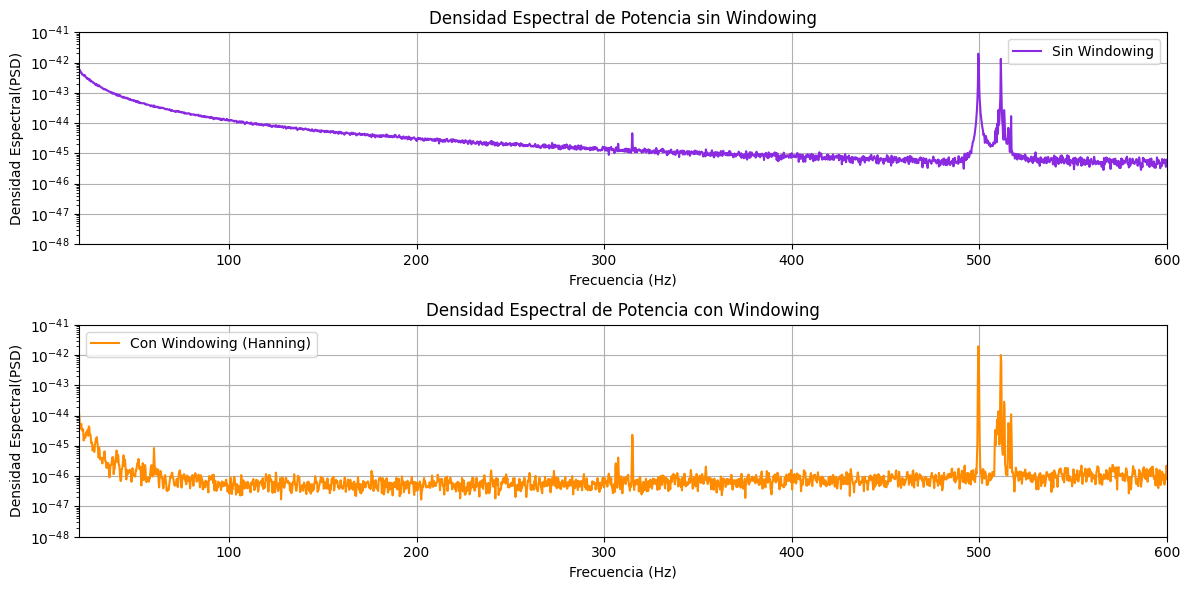

In [293]:
from scipy.signal.windows import hann
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import readligo as rl

# Se extraen los datos del archivo
datos, tiempo, dict = rl.loaddata(fn_L1)    
 
# Se setea el numero de muestras para la FFT
muestras = int(4 * fs)

# Se selecciona la funcion Hann para realizar el windowing
windowing = hann(muestras)

# Se hace la FFT para la señal sin windowing
densidad_espectral, frecuencia = mlab.psd(datos, Fs=fs, NFFT=muestras, window=mlab.window_none)
# Se hace la FFT para la señal con windowing
densidad_espectral_window, frecuencia_window = mlab.psd(datos, Fs=fs, NFFT=muestras, window=windowing)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.semilogy(frecuencia, densidad_espectral, color='blueviolet', label='Sin Windowing')
plt.title('Densidad Espectral de Potencia sin Windowing')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Densidad Espectral(PSD)') 
plt.axis([20, 600, 1e-48, 1e-41])
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.semilogy(frecuencia_window, densidad_espectral_window, color='darkorange', label='Con Windowing (Hanning)')
plt.title('Densidad Espectral de Potencia con Windowing')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Densidad Espectral(PSD)') 
plt.axis([20, 600, 1e-48, 1e-41])
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## 4. Procesamiento 
Debes inferir de tu estudio, cual es el proceso que aplican a la señal y reproducirlo. Es posible que cada estudiante llegue a una solución más o menos diferente, pues no hay un código abierto donde esté el procedimiento completo.


## 4.1 Encontrar tiempo de evento aproximado
Se busca el primer pico de la señal apra aproximar el tiempo de evento

In [311]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Encontrar picos en la señal
picos, _ = find_peaks(datos, height=10e-25)  # 'height' es el umbral para detectar picos

# Aproximar el tiempo de evento utilizando el primer pico encontrado
if len(picos) > 0:
    tiempo_evento_aproximado = tiempo[picos[0]]
    print("Tiempo de evento aproximado:", tiempo_evento_aproximado)
else:
    print("No se encontraron picos en la señal.")
    
# Ajuste a partir de tiempo de evento calculado
ajuste = np.where((tiempo >= tiempo_evento_aproximado) & (tiempo < tiempo_evento_aproximado + 4))

Tiempo de evento aproximado: 1186741846.000122


## 4.2 Gráfica de los datos sin windowing
Se gráfica en un rango de 4 segundos los datos orignales antes de aplicar windowing

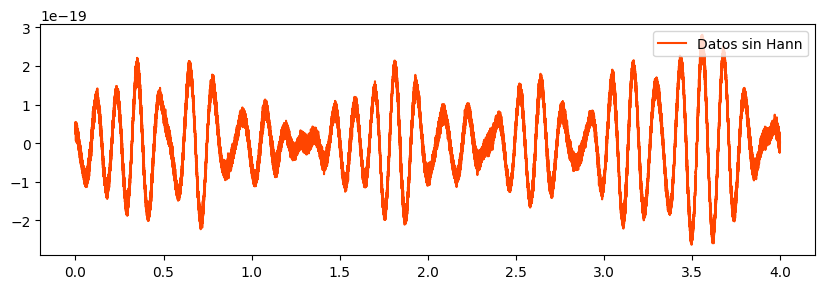

In [312]:
import numpy as np
import matplotlib.pyplot as plt

# Graficar datos ajustados
plt.figure(figsize=(10, 3))
plt.plot(tiempo[ajuste] - tiempo_evento_aproximado, datos[ajuste], label = 'Datos sin Hann', color = 'orangered')
plt.legend(loc='upper right')   

## 4.3 Gráfica de los datos con windowing
Se aplica Hann windowing a la señal

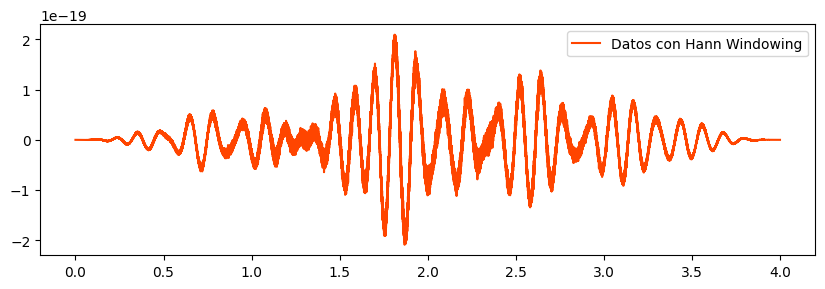

In [314]:
import matplotlib.pyplot as plt

# Graficar datos ventaneados
plt.figure(figsize=(10, 3))
windowing_ajustado = windowing * datos[ajuste]
plt.plot(tiempo[ajuste] - tiempo_evento_aproximado, windowing_ajustado, 'orangered', label='Datos con Hann Windowing')
plt.legend()

## 4.4 Gráfica filtrada con filtro pasa-banda
Se aplica un filtro de Butterworth de orden 4 entre las frecuencias 15 a 150 Hz

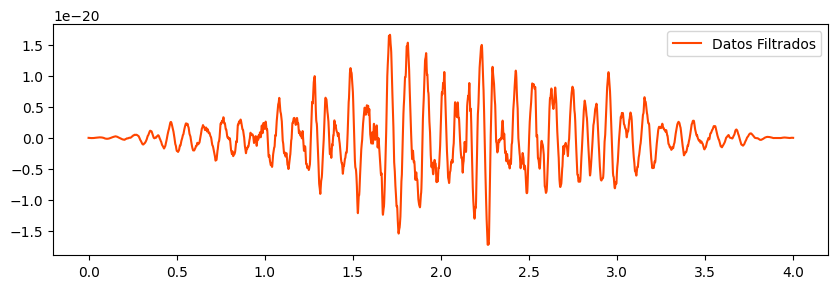

In [347]:
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

# plot bandpassed data
def bandpass(dst, fband, fs):
    bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='bandpass')
    normalizacion = np.sqrt((fband[1]-fband[0])/(fs/2))
    datos_pasabajo = filtfilt(bb, ab, dst) / normalizacion
    return datos_pasabajo

fband = [15.0, 150.0]

plt.figure(figsize=(10, 3))
datos_pasabajo = bandpass(windowing_ajustado, fband, fs)
plt.plot(tiempo[ajuste] - tiempo_evento_aproximado, datos_pasabajo, 'orangered', label='Datos Filtrados')
plt.legend(loc='upper right')

Se genera un audio .wav para revisar la onda gravitacional

In [298]:
import numpy as np
import scipy.io.wavfile as wavfile

# Normalizar la señal a un rango adecuado para audio
audio_signal = (datos_pasabajo - np.min(datos_pasabajo)) / (np.max(datos_pasabajo) - np.min(datos_pasabajo))
audio_signal = audio_signal * 2.0 - 1.0  # Escalar entre -1 y 1

# Guardar la señal como archivo .wav
wavfile.write('audio_gravitacional.wav', fs, audio_signal.astype(np.float32))

# Resampling
Para lograr una mejor definición de la señal, se debe hacer un resampleo. Esto tienen consecuencias por eso debe elegirse bien la frecuencia de tal forma que no se introduzca ruido.

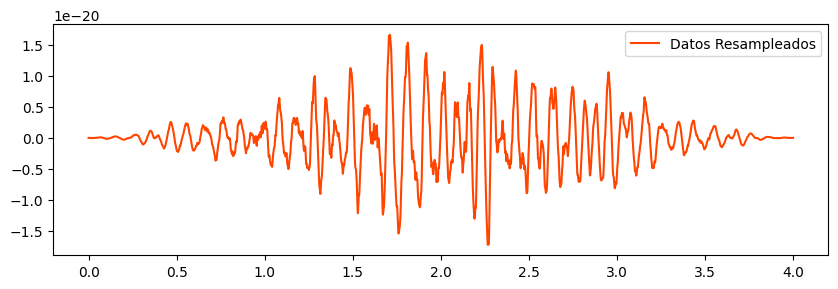

In [345]:
from scipy.signal import resample

# Resamplear la señal filtrada
nueva_fs = fs/4  # Nueva frecuencia de muestreo deseada
nuevo_num_puntos = int(len(datos_pasabajo) * nueva_fs / fs)
datos_pb_resampleados = resample(datos_pasabajo, nuevo_num_puntos)

# Calcular el tiempo para la señal remuestreada
tiempo_resampled = np.linspace(0, len(datos_pb_resampleados) / nueva_fs, len(datos_pb_resampleados))

# Graficar la señal remuestreada
plt.figure(figsize=(10, 3))
plt.plot(tiempo_resampled, datos_pb_resampleados, 'orangered', label='Datos Resampleados')
plt.legend(loc='upper right')
plt.show()


Se crea otro audio para revisar la onda gravitacional con la señal resampleada

In [346]:
import numpy as np
import scipy.io.wavfile as wavfile

# Normalizar la señal a un rango adecuado para audio
audio_signal2 = (datos_pb_resampleados - np.min(datos_pb_resampleados)) / (np.max(datos_pb_resampleados) - np.min(datos_pb_resampleados))
audio_signal2 = audio_signal2 * 2.0 - 1.0  # Escalar entre -1 y 1

# Guardar la señal como archivo .wav
wavfile.write('audio_gravitacional_resampleado.wav', fs, audio_signal2.astype(np.float32))